# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import torch
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline
from ddpg_agent import Agent, ReplayBuffer, MADDPG

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Instantiate the Environment and Agent

In [5]:
maagent = MADDPG(state_size = state_size, action_size = action_size)

### 4. Train the Agent with DDPG

D:\Anaconda3\envs\drlnd\lib\site-packages\torch\nn\functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Episode 100	  Mean_reward: 0.00 Average100 Score: 0.01
Episode 200	  Mean_reward: 0.00 Average100 Score: 0.00
Episode 300	  Mean_reward: 0.09 Average100 Score: 0.03
Episode 400	  Mean_reward: 0.10 Average100 Score: 0.15

Environment solved in 469 episodes!	Average100 Score: 0.51


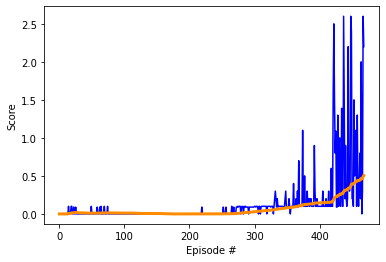

In [6]:
def ddpg(n_episodes=2100, max_t=1000, print_every=100):
    scores_deque = deque(maxlen=print_every)
    movingav = []
    scores = []
    time_stamp = 1
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]       
        states = env_info.vector_observations
        score = np.zeros(num_agents)                            

        while True:
            actions = maagent.act(states)
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            maagent.step(states, actions, rewards, next_states, dones, time_stamp)
                 
            states = next_states
            time_stamp +=1
            score += env_info.rewards
            if any(dones):
                break 
        
        scores.append(np.max(score))
        scores_deque.append(np.max(score))
        movingav.append(np.mean(scores_deque))
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\t  Mean_reward: {:.2f} Average100 Score: {:.2f}'.format(i_episode, np.max(score), movingav[-1]), end="\n")
        if movingav[-1] >= 0.5:
            print('\nEnvironment solved in {:d} episodes!\tAverage100 Score: {:.2f}'.format(i_episode, movingav[-1]))
            for idx, agent in enumerate(maagent.maddpg_agent):
                torch.save(agent.actor_local.state_dict(), "actor_agent"+str(idx)+".pth")
                torch.save(agent.critic_local.state_dict(), "critic_agent"+str(idx)+".pth")
            break
            
    return scores, movingav

scores, movingav = ddpg()

fig = plt.figure()
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores)
plt.plot(scores, label='Score', color='Blue')
plt.plot(movingav, label='Moving Average',
        color='DarkOrange', linewidth=3)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

When finished, you can close the environment.

In [7]:
env.close()